# Introduction to the Retina project – D7046E @ LTU.SE

This notebook serves as a starting point and playground for investigating what the 1D Retina project is about.
The idea is that you should familiarize yourself with both projects and later on decide which project to focus on (retina/SNN or chatbot/ANN).

In [ ]:
# Enable inline plots in the notebook
%matplotlib inline

# Import library functions needed
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Set default figure size
plt.rcParams['figure.figsize'] = [6,6]

# Function that is used to plot spike times
def rasterplot(ax, x, y, x_label, y_label):
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.scatter(x, y, marker='|')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))

# Basic data generator

The following animation illustrates a simple motion detection task. A bright spot is moving across a one-dimensonal array of virtual receptor neurons.

![Concept illustration](https://drive.google.com/uc?export=view&id=1dc4TQ84ui5i9oVnGH9Au5sZfHKzt-2jd)

The task is to determine whether the pattern is moving and whether it is moving towards the left or right. The following code implements a basic spike data generator inspired by the animation above. For simplicity it is assumed that a bright spot is moving at constant speed back and forth, and that one spike is generated when the bright spot is passing over a receptor neuron.

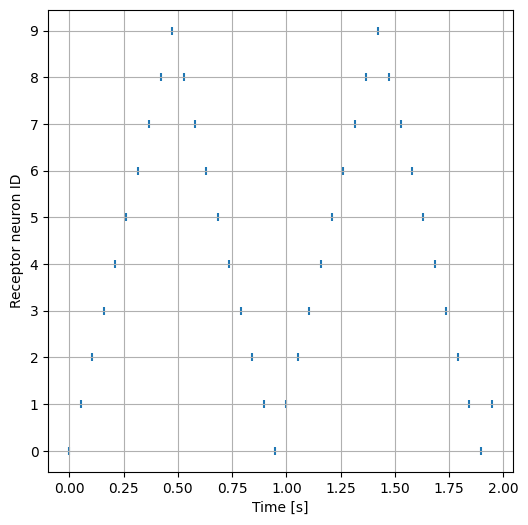

In [ ]:
####################################################################################################
# Simulation parameters
dt = 1e-4                    # Timestep
t = np.arange(0,20000)*dt    # Simulation time array t
num_receptors = 10           # Number of receptor neurons
speed = 20                   # Speed of bright spot, number of receptor neurons passed per second
####################################################################################################

plot_t = []                  # Time of spikes
plot_n = []                  # Receptor neuron id's
currtime = 0                 # Time when a spike is fired
neuronid = 0                 # Neuron that fires a spike
stepdir = 1                  # Is the bright spot moving towards the right (1) or left (-1)
timestep = 1.0/(speed-1)     # Time between spikes generated by nearby receptor neurons

# Make placeholders for spike time arrays to be used for SNN simulation
spikes = []
for i in range(num_receptors):
    spikes.append([])

# Generate and plot spikes from receptor neurons
while currtime < t[-1]:
    plot_t.append(currtime)
    plot_n.append(neuronid)
    spikes[neuronid].append(currtime)
    if neuronid == 0 and stepdir == -1:
        stepdir = 1
    elif neuronid == (num_receptors-1) and stepdir == 1:
        stepdir = -1
    neuronid += stepdir
    currtime += timestep

# Plot spikes
fig, ax = plt.subplots()
rasterplot(ax, plot_t, plot_n,'Time [s]','Receptor neuron ID')
ax.grid()

# Implement your first motion-detection SNN

There is a direction-selective network example in [Neuronify](https://ovilab.net/neuronify/), which is illustrated below. This network is designed so that the output neuron tends to fire a spike when the inputs are touched from right to left, but not when touched from left to right (with some limitations on the touching speed).

![First network implementation](https://drive.google.com/uc?export=view&id=1ZIyhUCtNebN1StlYCKEnC0qgXMZAF8d-)

Can you simulate this network using the code from SNN Exercise 1 and the input spikes provided by the data generator above? Can you modify the parameters of the simulated network so that it becomes direction selective?

If you succeed with this task then you have designed your first SNN vision system capable of basic motion detection!

**Note:** You need to complete SNN Exercise 1 to acquire the necessary background knowledge for this task.

In [ ]:
# To simulate the spikes from the receptor neurons you will need an additional neuron constructor defined as

def spike_generator(spike_times):
    # Generates spikes at time points defined by the sorted list 'spike_t'
    return {
        'type'      : 'generator',
        'spike_t'   : spike_times              # Array of spike times, separated by at least dt
}

# To incorporate this neuron type in the simulator you will need to update the spikegen(dt,t,neurons) function

def spikegen(dt, t, neurons):
    # This function implements the non-linear spike generation mechanism
    spikes = []
    for i,n in enumerate(neurons):
        if n['type'] in ['lif_cic','lif']:
            if n['u'] > n['u_thres']:
                n['u'] = n['u_reset']
                spikes.append(i)
        elif n['type'] == 'generator':
            j = np.searchsorted(n['spike_t'], t, side='right')
            if j>0 and t-n['spike_t'][j-1]<dt:
                spikes.append(i)
    return spikes

# With these modifications of the simulator code you should be able to simulate the receptor neurons using
# spike_generator neurons initialized with the spike time arrays produced by the data generator code above.

# The construction of neurons and configuration of synapses should be done in a similar way as in SNN Exercise 1.

In [2]:
import numpy as np
import pandas as pd
from google.colab import files

# Simulation parameters
dt = 1e-4
t = np.arange(0, 20000) * dt  # Time array
num_receptors = 10
num_steps = len(t)

# Initialize motion variables
position = 0  # Start at Receptor 0
direction = 1  # 1 = moving right, -1 = moving left
speed = 20  # Neurons per second

# Generate correct bouncing motion
positions = []
directions = []  # To store direction values for each step
last_activated = -1  # To track the last activated neuron

for i in range(num_steps):
    positions.append(position)  # Store position
    directions.append(direction)  # Store direction

    # Only print when a new neuron is activated
    rounded_position = round(position)
    if rounded_position != last_activated:
        print(f"Time: {t[i]:.4f}, Neuron Activated: {rounded_position}, Direction: {direction}")
        last_activated = rounded_position  # Update last activated neuron

    position += direction * speed * dt  # Move in the current direction

    # Reverse direction at boundaries (0 and 9)
    if position >= num_receptors - 1 or position <= 0:
        direction *= -1
        #Print only when direction changes
        #print(f"Time: {t[i]:.4f}, Direction Changed: {direction}, Neuron Activated: {rounded_position}")

# Convert to NumPy array
positions = np.array(positions)
positions = np.clip(np.round(positions).astype(int), 0, num_receptors - 1)
directions = np.array(directions)

# Create dataset (binary activation for receptors)
dataset = np.zeros((num_steps, num_receptors), dtype=int)
dataset[np.arange(num_steps), positions] = 1

# Convert to DataFrame
df = pd.DataFrame(dataset, columns=[f"Receptor_{i}" for i in range(num_receptors)])
df.insert(0, "Time", t)
df.insert(1, "Direction", directions)  # Add direction column

# Save the dataset
df.to_csv("bright_spot_bounce_fixed.csv", index=False)
#files.download("bright_spot_bounce_fixed.csv")

Time: 0.0000, Neuron Activated: 0, Direction: 1
Time: 0.0250, Neuron Activated: 1, Direction: 1
Time: 0.0750, Neuron Activated: 2, Direction: 1
Time: 0.1251, Neuron Activated: 3, Direction: 1
Time: 0.1751, Neuron Activated: 4, Direction: 1
Time: 0.2251, Neuron Activated: 5, Direction: 1
Time: 0.2751, Neuron Activated: 6, Direction: 1
Time: 0.3251, Neuron Activated: 7, Direction: 1
Time: 0.3751, Neuron Activated: 8, Direction: 1
Time: 0.4251, Neuron Activated: 9, Direction: 1
Time: 0.4752, Neuron Activated: 8, Direction: -1
Time: 0.5252, Neuron Activated: 7, Direction: -1
Time: 0.5752, Neuron Activated: 6, Direction: -1
Time: 0.6252, Neuron Activated: 5, Direction: -1
Time: 0.6752, Neuron Activated: 4, Direction: -1
Time: 0.7252, Neuron Activated: 3, Direction: -1
Time: 0.7752, Neuron Activated: 2, Direction: -1
Time: 0.8253, Neuron Activated: 1, Direction: -1
Time: 0.8753, Neuron Activated: 0, Direction: -1
Time: 0.9254, Neuron Activated: 1, Direction: 1
Time: 0.9754, Neuron Activated:

# Further project work

The challenge for the **1D Retina project** is to develop a more advanced vision system for (1D) motion classification, which is not limited to one specific pattern like the bright spot in the basic data generator above.

For example, you could consider using an open image dataset for training, validation and testing. For testing, the output of a webcam could optionally be considered. The delta modulator concept introduced in SNN Exercise 1 could potentially be used to convert pixel intensities to spikes. Optionally, you can use a [DAVIS346 neuromorphic vision sensor](https://inivation.github.io/inivation-docs/Hardware%20user%20guides/User_guide_-_DAVIS346.html) to record your own dataset.

Some inspiration for the SNN network architecture and training protocol can be obtained also from SNN Exercise 2. The [Reichardt Detector](https://en.wikipedia.org/wiki/Motion_perception#The_Reichardt-Hassenstein_model) is one starting point. For further inspiration, consider for example [motion detection in insects](https://link.springer.com/content/pdf/10.1007/s00359-019-01375-9.pdf).

In addition to considering differnt types of receptor models and SNN architectures for efficient and reliable motion classification, you can consider using other SNN simulators like [Brian2](https://brian2.readthedocs.io). Optionally you can consider using accelerators like [Brian2GeNN](https://brian2genn.readthedocs.io/en/stable/introduction/).

The possibilities for exploration are endless! How does the human retina work?

membrane potentials: [ 0.47740754 -0.49433464]
predicted: LEFT spikes: [ True False] 
membrane potentials: [ 0.95763877 -0.97440079]
predicted: LEFT spikes: [ True False] 
membrane potentials: [ 1.43532708 -1.45192564]
predicted: LEFT spikes: [ True False] 
membrane potentials: [ 1.90635096 -1.92278764]
predicted: LEFT spikes: [ True False] 
membrane potentials: [ 2.37321056 -2.38948694]
predicted: LEFT spikes: [ True False] 
membrane potentials: [ 2.83474806 -2.85086571]
predicted: LEFT spikes: [ True False] 
membrane potentials: [ 3.29271258 -3.30867304]
predicted: LEFT spikes: [ True False] 
membrane potentials: [ 3.74676379 -3.76256859]
predicted: LEFT spikes: [ True False] 
membrane potentials: [ 4.19489452 -4.21054519]
predicted: LEFT spikes: [ True False] 
membrane potentials: [ 4.64089752 -4.65639555]
predicted: LEFT spikes: [ True False] 
membrane potentials: [ 5.07905585 -5.09440275]
predicted: LEFT spikes: [ True False] 
Early stopping
(2,)


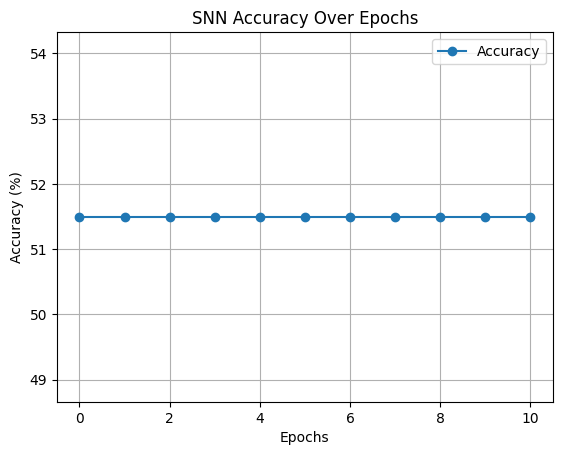

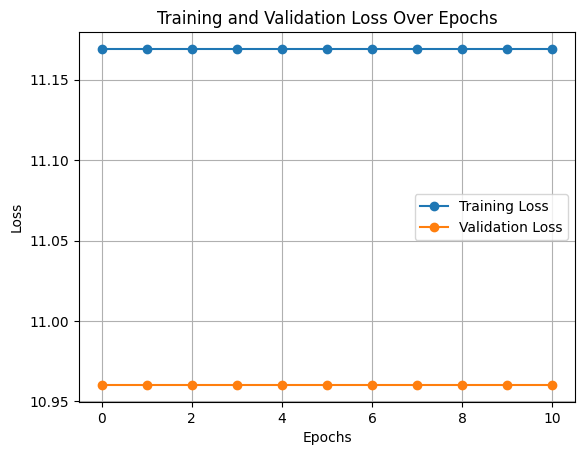

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def spike_count_loss(spikes, actual_output):
    return -np.sum(actual_output * np.log(spikes + 1e-10))  # Cross-entropy loss

# SNN Parameters
dt = 1e-4
num_receptors = 10
num_outputs = 2  # Left (0) and Right (1)
threshold = 0.08  # Spike threshold
time_steps = 20000
inhibition_strength = 0.01
learning_rate = 7e-3  # Adjusted learning rate
momentum = 0.6  # Momentum for weight updates
l2_lambda = 0.001  # L2 regularization strength
batch_size = 25  # Batch size for training
epochs = 50
patience = 10  # Early stopping patience

# Load dataset
df = pd.read_csv("bright_spot_bounce_fixed.csv")
time = df["Time"].values
spike_inputs = df.iloc[:, 2:].values  # Exclude Time and Direction columns
labels = df["Direction"].values

# Split into training (70%) and temp (30%) 20 000 total
training_set, temp_df = train_test_split(df, test_size=0.30, random_state=42)

# Split temp into validation (15%) and test (15%)
validation_set, test_set = train_test_split(temp_df, test_size=0.50, random_state=42)

# Check sizes
#print(f"Train: {len(training_set)}, Validation: {len(validation_set)}, Test: {len(test_set)}")

# Initialize synaptic weights using He initialization
weights = np.random.randn(2, num_receptors) * 0.01

# Initialize optimizer variables (for SGD with momentum)
velocity = np.zeros_like(weights)  # Momentum term

# Track loss
training_loss, validation_loss = [], []

# Keep track of best validation loss
best_loss = float('inf')
epochs_without_improvement = 0

# Track accuracy
accuracies = []

# Training loop
for epoch in range(epochs):
    correct_predictions = 0  # Reset accuracy tracking per epoch
    epoch_training_loss = 0
    epoch_validation_loss = 0

    # Shuffle training data for better generalization
    training_set = training_set.sample(frac=1, random_state=epoch).reset_index(drop=True)



    # Batch processing
    for t in range(0, len(training_set), batch_size):
        batch = training_set.iloc[t:t+batch_size]
        batch_loss = 0
        weight_gradients = np.zeros_like(weights)  # Accumulate gradients for the batch

        for _, row in batch.iterrows():
            input_spikes = row[2:].values
            membrane_potentials = np.zeros(num_outputs)  # Reset potentials per sample

            # Compute input current
            input_current = np.dot(weights, input_spikes)

            # Update membrane potential
            membrane_potentials += input_current

            # Check for spikes
            spikes = membrane_potentials >= threshold

            # Reset potentials where spikes occurred
            membrane_potentials[spikes] = 0


            if not(spikes[0] and spikes[1]):  # Both neurons fired
                winner = np.argmax(membrane_potentials)  # Choose stronger neuron
                spikes[:] = False
                spikes[winner] = True  # Keep only winner

            # Prediction logic
            if spikes[0] and not spikes[1]:
                prediction = "LEFT"
                membrane_potentials[0] = 0  # Suppress left
            elif spikes[1] and not spikes[0]:
                prediction = "RIGHT"
                membrane_potentials[1] = 0  # Suppress right
            else:
                prediction = "NONE"

            actual = "RIGHT" if row["Direction"] == 1 else "LEFT" if row["Direction"] == -1 else "NONE"



            # Track accuracy
            if prediction == actual:
                correct_predictions += 1

            # Calculate loss
            actual_output = np.array([row["Direction"] == -1, row["Direction"] == 1])  # [Left, Right]
            loss = spike_count_loss(spikes, actual_output)
            batch_loss += loss

            # Compute gradients for weight update
            error = actual_output.astype(int) - spikes.astype(int)
            weight_gradients += np.outer(error, input_spikes)

        # Average gradients over the batch
        weight_gradients /= len(batch)

        # SGD with momentum and L2 regularization
        velocity = momentum * velocity - learning_rate * (weight_gradients + l2_lambda * weights)
        weights += velocity

        epoch_training_loss += batch_loss / len(batch)

    # Save training loss
    training_loss.append(epoch_training_loss / (len(training_set) / batch_size))

################################################################################
################################################################################

    # Validation loop
    correct_validation_predictions = 0
    for t in range(len(validation_set)):
        input_spikes = validation_set.iloc[t, 2:].values
        membrane_potentials = np.zeros(num_outputs)

        # Compute input current
        input_current = np.dot(weights, input_spikes)

        # Update membrane potential
        membrane_potentials += input_current

        # Check for spikes
        spikes = membrane_potentials >= threshold

        # Reset potentials where spikes occurred

        # # Inhibition
        # if spikes[0]:
        #     #membrane_potentials[1] -= inhibition_strength  # Suppress right
        #     membrane_potentials[1] = 0
        # elif spikes[1]:
        #     #membrane_potentials[0] -= inhibition_strength  # Suppress left
        #     membrane_potentials[0] = 0

        # Prediction logic
        if spikes[0] and not spikes[1]:
            prediction = "LEFT"
        elif spikes[1] and not spikes[0]:
            prediction = "RIGHT"
        else:
            prediction = "NONE"

        actual = "RIGHT" if validation_set.iloc[t]["Direction"] == 1 else "LEFT" if validation_set.iloc[t]["Direction"] == -1 else "NONE"

        # Track accuracy
        if prediction == actual:
            correct_validation_predictions += 1

        # Calculate validation loss
        actual_output = np.array([validation_set.iloc[t]["Direction"] == -1, validation_set.iloc[t]["Direction"] == 1])  # [Left, Right]
        loss = spike_count_loss(spikes, actual_output)
        epoch_validation_loss += loss

################################################################################
################################################################################

    #predictions
    print(f"membrane potentials: {membrane_potentials}")
    print(f"predicted: {prediction} spikes: {spikes} ")

    # Save validation loss
    validation_loss.append(epoch_validation_loss / len(validation_set))

    # Track accuracy
    accuracy = correct_predictions / len(training_set) * 100
    accuracies.append(accuracy)

    # Print progress
    #print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {training_loss[-1]}, Validation Loss: {validation_loss[-1]}, Accuracy: {accuracy:.2f}%")

    # Early stopping
    if validation_loss[-1] < best_loss:
        best_loss = validation_loss[-1]
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping")
            break



print(membrane_potentials.shape)
# Plot Accuracy Over Epochs
plt.plot(range(len(accuracies)), accuracies, label="Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("SNN Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Plot Training and Validation Loss
plt.plot(range(len(training_loss)), training_loss, label="Training Loss", marker="o")
plt.plot(range(len(validation_loss)), validation_loss, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()